In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm

import math
from matplotlib.ticker import MaxNLocator

Scenarios saved to /root/Downloads/oecd_benchmark_scenarios.csv
Plot saved to /root/Downloads/OECD_benchmark_scenarios.pdf


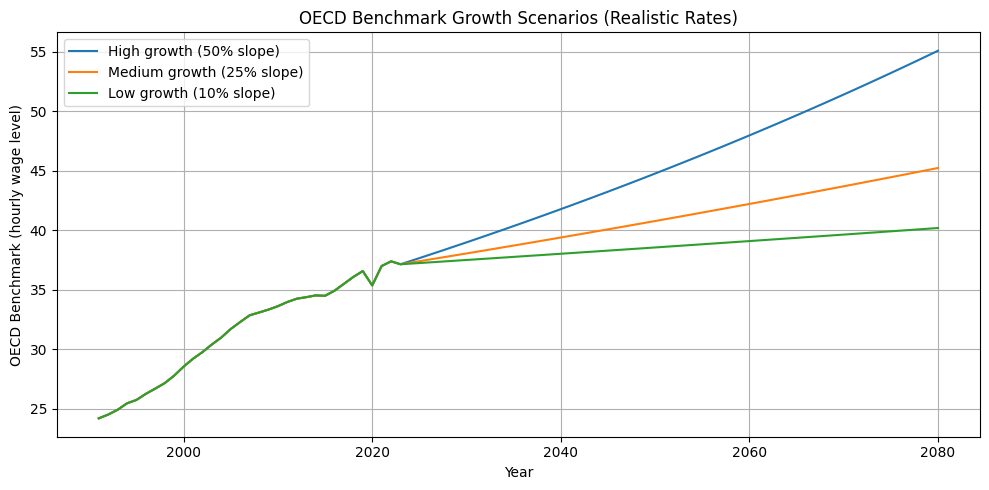

In [13]:
# ================================================
# 1. LOAD & LOG‑TRANSFORM YOUR WAGE DATA
# ================================================
df = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Countries_Wages_Estimates_Finals_GOOD.csv')

df['log_wage'] = np.log(df['estimated_hourly_wage'])

# ================================================
# 2. COMPUTE HISTORICAL OECD BENCHMARK (1991–2023)
# ================================================
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States'
}

hist = (
    df[df['country'].isin(oecd) & df['year'].between(1991, 2023)]
      .groupby('year')['log_wage']
      .mean()
      .rename('benchmark_log')
      .to_frame()
)

years_hist = hist.index.values            # [1991 … 2023]
loghist    = hist['benchmark_log'].values # log‐benchmark
last_year  = years_hist[-1]
last_log   = loghist[-1]

# ================================================
# 3. FIT HIGH‑GROWTH LINEAR TREND ON LOG
# ================================================
lin_model = LinearRegression().fit(
    years_hist.reshape(-1,1),
    loghist
)
slope_lin     = lin_model.coef_[0]
intercept_lin = lin_model.intercept_

# ================================================
# 4. DEFINE “REALISTIC” HIGH/MEDIUM/LOW SLOPES
#    High = 50% of hist slope (~2% p.a.)
#    Medium = 25% (~1% p.a.)
#    Low = 10% (~0.4% p.a.)
# ================================================
high_slope     = 0.50 * slope_lin
high_intercept = last_log - high_slope * last_year

med_slope      = 0.25 * slope_lin
med_intercept  = last_log - med_slope * last_year

low_slope      = 0.10 * slope_lin
low_intercept  = last_log - low_slope * last_year

# ================================================
# 5. FORECAST 2024–2080
# ================================================
extrap_year = 2080
years_fut   = np.arange(2024, extrap_year+1)

high_log   = high_slope  * years_fut + high_intercept
medium_log = med_slope   * years_fut + med_intercept
low_log    = low_slope    * years_fut + low_intercept

# ================================================
# 6. CONCATENATE & EXPONENTIATE BACK TO LEVELS
# ================================================
years_full      = np.concatenate([years_hist,    years_fut])
bench_high      = np.exp(np.concatenate([loghist,    high_log]))
bench_medium    = np.exp(np.concatenate([loghist,    medium_log]))
bench_low       = np.exp(np.concatenate([loghist,    low_log]))

# ================================================
# 7. BUILD A DATAFRAME & SAVE
# ================================================
bench_df = pd.DataFrame({
    'year':             years_full,
    'benchmark_high':   bench_high,
    'benchmark_medium': bench_medium,
    'benchmark_low':    bench_low,
})

# Define the output directory and create it if it doesn't exist
output_dir = os.path.expanduser('~/Downloads')
os.makedirs(output_dir, exist_ok=True)

# Define the output file paths within the created directory
out_csv = os.path.join(output_dir, 'oecd_benchmark_scenarios.csv')
out_pdf = os.path.join(output_dir, 'OECD_benchmark_scenarios.pdf')


# Save the DataFrame to the local CSV file
bench_df.to_csv(out_csv, index=False)
print(f"Scenarios saved to {out_csv}")

# ================================================
# 8. PLOT THE THREE SCENARIOS
# ================================================
plt.figure(figsize=(10, 5))
plt.plot(bench_df['year'], bench_df['benchmark_high'],   color='C0', label='High growth (50% slope)')
plt.plot(bench_df['year'], bench_df['benchmark_medium'], color='C1', label='Medium growth (25% slope)')
plt.plot(bench_df['year'], bench_df['benchmark_low'],    color='C2', label='Low growth (10% slope)')
plt.xlabel('Year')
plt.ylabel('OECD Benchmark (hourly wage level)')
plt.title('OECD Benchmark Growth Scenarios (Realistic Rates)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Save the figure to:
plt.savefig(out_pdf, dpi=300)
print(f"Plot saved to {out_pdf}")

plt.show()

In [14]:
# V29 is my V28 from file V5 simply to get it clean here – V27 plus split into convergers / divergers by low-scenario 70% threshold

# ── 1. LOAD DATA & OECD SCENARIOS ─────────────────────────────────────────────
df = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Countries_Wages_Estimates_Finals_GOOD.csv')
df['log_wage'] = np.log(df['estimated_hourly_wage'])
df['country'] = df['country'].str.replace('\u00A0', ' ').str.strip()

bench_df = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/oecd_benchmark_scenarios.csv')

# ── 2. EXCLUDE OECD COUNTRIES & MERGE SCENARIOS ─────────────────────────────────
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States'
}
df2 = (
    df
      .merge(bench_df, on='year', how='left')
      .query("country not in @oecd")
      .dropna(subset=['benchmark_high'])
)

# ── 3. MODEL CANDIDATES & ROLLING-ORIGIN SPLITS ──────────────────────────────────
def exp_decay(tc, A, k, C):
    return A * np.exp(-k*tc) + C

def logistic(tc, L, k, C):
    return C + L / (1 + np.exp(-k*tc))

tscv = TimeSeriesSplit(n_splits=5)

# ── 4. THRESHOLDS & OUTPUT SETUP ───────────────────────────────────────────────
extrap_year = bench_df['year'].max()
thr_levels  = [0.7, 0.8, 0.9]
log_thr     = {lvl: np.log(lvl) for lvl in thr_levels}

results = []

# ── 5. LOOP OVER NON-OECD COUNTRIES & PLOT ──────────────────────────────────────
with PdfPages(os.path.expanduser(
    '~/Downloads/V30_convergence_three_scenarios_nonOECD_plateau.pdf'
)) as pdf:

    for country, sub in df2.groupby('country'):
        sub = sub.sort_values('year')
        if len(sub) < 6:
            continue

        years_hist = sub['year'].values
        t0         = years_hist.min()
        tc_hist    = (years_hist - t0).reshape(-1,1)
        logw_hist  = sub['log_wage'].values

        # a) Rolling-origin CV for candidate models
        candidate_errors = {}
        pipelines = {
            'Linear': LinearRegression(),
            'Quadratic': Pipeline([('poly', PolynomialFeatures(2)),('lr',LinearRegression())]),
            'Sqrt': Pipeline([('sqrt', FunctionTransformer(np.sqrt,validate=False)),('lr',LinearRegression())])
        }
        for name, model in pipelines.items():
            errs = []
            for tr, te in tscv.split(tc_hist):
                model.fit(tc_hist[tr], logw_hist[tr])
                errs.append(mean_squared_error(
                    logw_hist[te], model.predict(tc_hist[te])
                ))
            candidate_errors[name] = np.mean(errs)

        # b) CV for ExpDecay & Logistic
        for name, func in [('ExpDecay', exp_decay), ('Logistic', logistic)]:
            errs = []
            for tr, te in tscv.split(tc_hist):
                Xtr = tc_hist[tr].ravel(); Ytr = logw_hist[tr]
                try:
                    p0 = [Ytr[0]-Ytr[-1],0.02,Ytr[-1]] if name=='ExpDecay' else [Ytr.max()-Ytr.min(),0.1,Ytr.min()]
                    popt, _ = curve_fit(func, Xtr, Ytr, p0=p0,
                                        bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
                    preds = func(tc_hist[te].ravel(), *popt)
                    errs.append(mean_squared_error(logw_hist[te], preds))
                except:
                    errs=[]
                    break
            if errs:
                candidate_errors[name] = np.mean(errs)

        # c) Select & refit best
        best = min(candidate_errors, key=candidate_errors.get)
        if best in pipelines:
            final_model = pipelines[best].fit(tc_hist, logw_hist)
            predict = lambda X: final_model.predict(X)
        else:
            fn = exp_decay if best=='ExpDecay' else logistic
            p0 = [logw_hist[0]-logw_hist[-1],0.02,logw_hist[-1]] if best=='ExpDecay' else [logw_hist.max()-logw_hist.min(),0.1,logw_hist.min()]
            popt, _ = curve_fit(fn, tc_hist.ravel(), logw_hist, p0=p0,
                                bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
            predict = lambda X, fn=fn, popt=popt: fn(X.ravel(),*popt)

        # d) Forecast & plateau cap
        years_fut = np.arange(years_hist.max()+1, extrap_year+1)
        tc_fut    = (years_fut - t0).reshape(-1,1)
        logw_fut  = predict(tc_fut)
        gaps_hist = logw_hist - np.log(sub['benchmark_high'].values)
        gaps_fut  = {}
        for s in ['high','medium','low']:
            raw = logw_fut - np.log(bench_df.set_index('year')[f'benchmark_{s}'].reindex(years_fut).values)
            gaps_fut[s] = np.minimum(raw, 0.0)

        # e) Record summary, including gap_low_2080
        row = {
            'country':     country,
            'best_model':  best,
            'cv_mse':      round(candidate_errors[best],4),
            'gap_low_2080': round(gaps_fut['low'][-1],4)
        }
        for s, code in zip(['high','medium','low'], ['H','M','L']):
            for lvl in thr_levels:
                idx = np.where(gaps_fut[s] >= np.log(lvl))[0]
                row[f'{code}-{int(lvl*100)}'] = 'X' if idx.size==0 else str(years_fut[idx[0]])
        results.append(row)

        # f) Plot with thresholds
        plt.figure(figsize=(7,4))
        plt.plot(years_hist, gaps_hist, 'ko-', label='Hist gap')
        for s, c in zip(['high','medium','low'], ['C0','C1','C2']):
            plt.plot(years_fut, gaps_fut[s], '--', color=c, label=s.capitalize())
        plt.axhline(0,           color='black', linestyle='--', linewidth=1)
        plt.axhline(np.log(0.7), color='blue',  linestyle=':',  label='70% thresh')
        plt.axhline(np.log(0.8), color='green', linestyle='-.', label='80% thresh')
        plt.axhline(np.log(0.9), color='red',   linestyle='--', label='90% thresh')
        plt.title(country)
        plt.xlabel('Year'); plt.ylabel('Log wage gap vs OECD')
        plt.legend(); plt.grid(True)
        pdf.savefig()
        plt.close()


# ── 6. SAVE RAW SUMMARY CSV ───────────────────────────────────────────────────
out_raw = os.path.expanduser(
    '~/Downloads/V30_convergence_three_scenarios_nonOECD_plateau_summary.csv'
)
pd.DataFrame(results).to_csv(out_raw, index=False)
print("Raw summary →", out_raw)

# ── 7. SPLIT INTO CONVERGERS / DIVERGERS & SAVE ────────────────────────────────
df_res = pd.DataFrame(results)

# flag those that hit low-scenario 70% by 2080
df_res['converges_low70'] = df_res['L-70'] != 'X'

# convergers: sort by year they cross L-70
conv = df_res[df_res['converges_low70']].copy()
conv['year_low70'] = conv['L-70'].astype(int)
conv = conv.sort_values('year_low70').drop(columns='year_low70')

# divergers: those with X, sort by gap_low_2080 (closest to zero first)
div = df_res[~df_res['converges_low70']].copy()
div = div.sort_values('gap_low_2080', ascending=False)

# save both
out_conv = os.path.expanduser('~/Downloads/V30_convergers_low70.csv')
out_div  = os.path.expanduser('~/Downloads/V30_divergers_low70.csv')
conv.to_csv(out_conv, index=False)
div.to_csv(out_div,  index=False)
print("Convergers →", out_conv)
print("Divergers  →", out_div)


Raw summary → /root/Downloads/V30_convergence_three_scenarios_nonOECD_plateau_summary.csv
Convergers → /root/Downloads/V30_convergers_low70.csv
Divergers  → /root/Downloads/V30_divergers_low70.csv


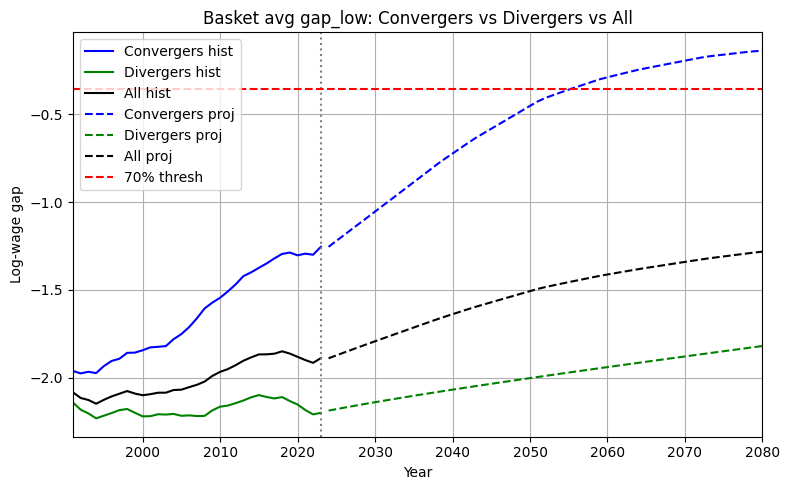

In [15]:


# ── 1) helper functions & CV setup ────────────────────────────────────────────
def exp_decay(tc, A, k, C): return A * np.exp(-k*tc) + C
def logistic(tc, L, k, C):  return C + L/(1+np.exp(-k*tc))

tscv = TimeSeriesSplit(n_splits=5)
pipelines = {
    'Linear': LinearRegression(),
    'Quadratic': Pipeline([('poly', PolynomialFeatures(2)),('lr',LinearRegression())]),
    'Sqrt': Pipeline([('sqrt', FunctionTransformer(np.sqrt,validate=False)),('lr',LinearRegression())])
}

# ── 2) load converger & diverger lists ───────────────────────────────────────
conv = pd.read_csv(os.path.expanduser('~/Downloads/V30_convergers_low70.csv'))
div  = pd.read_csv(os.path.expanduser('~/Downloads/V30_divergers_low70.csv'))
conv_countries = conv['country'].tolist()
div_countries  = div['country'].tolist()
all_countries  = list(set(conv_countries + div_countries))

# ── 3) load wage data & OECD benchmarks ──────────────────────────────────────
df['log_wage'] = np.log(df['estimated_hourly_wage'])
df['country']  = df['country'].str.replace('\u00A0',' ').str.strip()

bench = bench_df.copy().set_index('year')

# ── 4) prepare non-OECD merged df2 ────────────────────────────────────────────
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States'
}
df2 = (
    df.merge(bench, on='year', how='left')
      .query("country not in @oecd")
      .dropna(subset=['benchmark_low'])
)

# ── 5) global future-years vector ─────────────────────────────────────────────
years_fut = np.arange(2024, bench.index.max()+1)

# ── 6) function to build low-scenario gaps for any country list ──────────────
def build_low_gaps(country_list):
    low_gaps = {}
    for country in country_list:
        sub = df2[df2['country']==country].sort_values('year')
        if len(sub) < 6: continue

        # history arrays
        y       = sub['year'].values
        t0      = y.min()
        tc_hist = (y - t0).reshape(-1,1)
        lw_hist = sub['log_wage'].values

        # 1) CV to pick best model
        errs = {}
        for name,model in pipelines.items():
            mses=[]
            for tr,te in tscv.split(tc_hist):
                model.fit(tc_hist[tr], lw_hist[tr])
                mses.append(mean_squared_error(lw_hist[te], model.predict(tc_hist[te])))
            errs[name] = np.mean(mses)
        for name,fn in [('ExpDecay',exp_decay),('Logistic',logistic)]:
            mses=[]
            for tr,te in tscv.split(tc_hist):
                Xtr, Ytr = tc_hist[tr].ravel(), lw_hist[tr]
                p0 = [Ytr[0]-Ytr[-1],0.02,Ytr[-1]] if name=='ExpDecay' else [Ytr.max()-Ytr.min(),0.1,Ytr.min()]
                try:
                    p,_ = curve_fit(fn, Xtr, Ytr, p0=p0,
                                    bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
                    preds = fn(tc_hist[te].ravel(), *p)
                    mses.append(mean_squared_error(lw_hist[te], preds))
                except:
                    mses=[]
                    break
            if mses:
                errs[name] = np.mean(mses)

        # 2) refit best on full history
        best = min(errs, key=errs.get)
        if best in pipelines:
            model = pipelines[best].fit(tc_hist, lw_hist)
            predict = lambda X: model.predict(X)
        else:
            fn = exp_decay if best=='ExpDecay' else logistic
            p0 = [lw_hist[0]-lw_hist[-1],0.02,lw_hist[-1]] if best=='ExpDecay' else [lw_hist.max()-lw_hist.min(),0.1,lw_hist.min()]
            p,_ = curve_fit(fn, tc_hist.ravel(), lw_hist, p0=p0,
                            bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
            predict = lambda X,fn=fn,p=p: fn(X.ravel(), *p)

        # 3) last observed gap_low
        hist_bench = np.log( bench.reindex(y)['benchmark_low'].values )
        last_gap   = (lw_hist - hist_bench)[-1]

        # 4) forecast & raw gap_low
        tc_f = (years_fut - t0).reshape(-1,1)
        lw_f = predict(tc_f)
        raw  = lw_f - np.log( bench.reindex(years_fut)['benchmark_low'].values )
        gap_f = np.minimum(raw, 0.0)

        # 5) stitch continuity
        gap_f = gap_f - gap_f[0] + last_gap

        low_gaps[country] = gap_f

    return low_gaps

# ── 7) build projected gaps for each basket ─────────────────────────────────
low_gaps_conv = build_low_gaps(conv_countries)
low_gaps_div  = build_low_gaps(div_countries)
low_gaps_all  = build_low_gaps(all_countries)

# ── 8) turn into DataFrames & compute basket means ─────────────────────────
gap_conv_df = pd.DataFrame(low_gaps_conv, index=years_fut)
gap_div_df  = pd.DataFrame(low_gaps_div,  index=years_fut)
gap_all_df  = pd.DataFrame(low_gaps_all,  index=years_fut)

avg_conv_fut = gap_conv_df.mean(axis=1)
avg_div_fut  = gap_div_df.mean(axis=1)
avg_all_fut  = gap_all_df.mean(axis=1)

# ── 9) compute historical basket averages ───────────────────────────────────
def basket_hist(countries):
    sub = df2[df2['country'].isin(countries)].copy()
    sub['gap_low'] = np.log(sub['estimated_hourly_wage']) - np.log(sub['benchmark_low'])
    return sub.groupby('year')['gap_low'].mean()

hist_conv = basket_hist(conv_countries)
hist_div  = basket_hist(div_countries)
hist_all  = basket_hist(all_countries)

# ── 10) plot all three baskets on one graph ─────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(hist_conv.index, hist_conv.values, 'b-', label='Convergers hist')
plt.plot(hist_div.index,  hist_div.values,  'g-', label='Divergers hist')
plt.plot(hist_all.index,  hist_all.values,  'k-', label='All hist')

plt.plot(years_fut, avg_conv_fut, 'b--', label='Convergers proj')
plt.plot(years_fut, avg_div_fut,  'g--', label='Divergers proj')
plt.plot(years_fut, avg_all_fut,  'k--', label='All proj')

plt.axvline(2023, color='gray', linestyle=':')
plt.axhline(np.log(0.7), color='red', linestyle='--', label='70% thresh')
plt.xlim(1991, bench.index.max())
plt.xlabel('Year'); plt.ylabel('Log-wage gap')
plt.title('Basket avg gap_low: Convergers vs Divergers vs All')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.expanduser('~/Downloads/New_basket_avg_gap_low.pdf'), format='pdf', dpi=300)

plt.show()


In [16]:
# Load data and take logs
df['log_wage'] = np.log(df['estimated_hourly_wage'])

# ──────────────────────────────────────────────────────────────────────────────
# 1. Sigma Convergence
#    Annual dispersion (standard deviation) of log‐wages
# ──────────────────────────────────────────────────────────────────────────────
sigma_series = df.groupby('year')['log_wage'].std().reset_index(name='sigma')

plt.figure(figsize=(8,4))
plt.plot(
    sigma_series['year'],
    sigma_series['sigma'],
    color='C0',
    linewidth=2,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=1.5
)
plt.title('Sigma Convergence: Dispersion of Log Wages Over Time', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Std. Dev. of Log Wages', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

sigma_pdf = os.path.expanduser('~/Downloads/sigma_convergence_GOOD.pdf')
plt.savefig(sigma_pdf, format='pdf')
plt.close()

# ──────────────────────────────────────────────────────────────────────────────
# 2. Beta Convergence
#    Cross‐sectional regression of annualized growth on initial log wage
# ──────────────────────────────────────────────────────────────────────────────
start, end = df['year'].min(), df['year'].max()
pivot = df.pivot(index='country', columns='year', values='log_wage')
mask = pivot[start].notna() & pivot[end].notna()
pivot = pivot.loc[mask, [start, end]]

growth = (pivot[end] - pivot[start]) / (end - start)
initial = pivot[start]

X = sm.add_constant(initial)
beta_model = sm.OLS(growth, X).fit()

plt.figure(figsize=(8,4))
plt.scatter(
    initial, growth,
    c='C1', edgecolors='white', linewidth=0.8,
    alpha=0.8, s=50
)
x0, x1 = initial.min(), initial.max()
xs = np.linspace(x0, x1, 200)
ys = beta_model.params['const'] + beta_model.params[start] * xs
plt.plot(xs, ys, color='C2', linewidth=2)

plt.title('Beta Convergence: Growth Rate vs Initial Log Wage', fontsize=12)
plt.xlabel(f'Initial Log Wage ({start})', fontsize=10)
plt.ylabel('Annualized Growth Rate of Log Wage', fontsize=10)
plt.text(
    0.05, 0.95,
    f"β = {beta_model.params[start]:.3f}\np = {beta_model.pvalues[start]:.3f}",
    transform=plt.gca().transAxes, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

beta_pdf = os.path.expanduser('~/Downloads/beta_convergence_GOOD.pdf')
plt.savefig(beta_pdf, format='pdf')
plt.close()

print(f"Sigma plot → {sigma_pdf}")
print(f"Beta plot  → {beta_pdf}")


Sigma plot → /root/Downloads/sigma_convergence_GOOD.pdf
Beta plot  → /root/Downloads/beta_convergence_GOOD.pdf


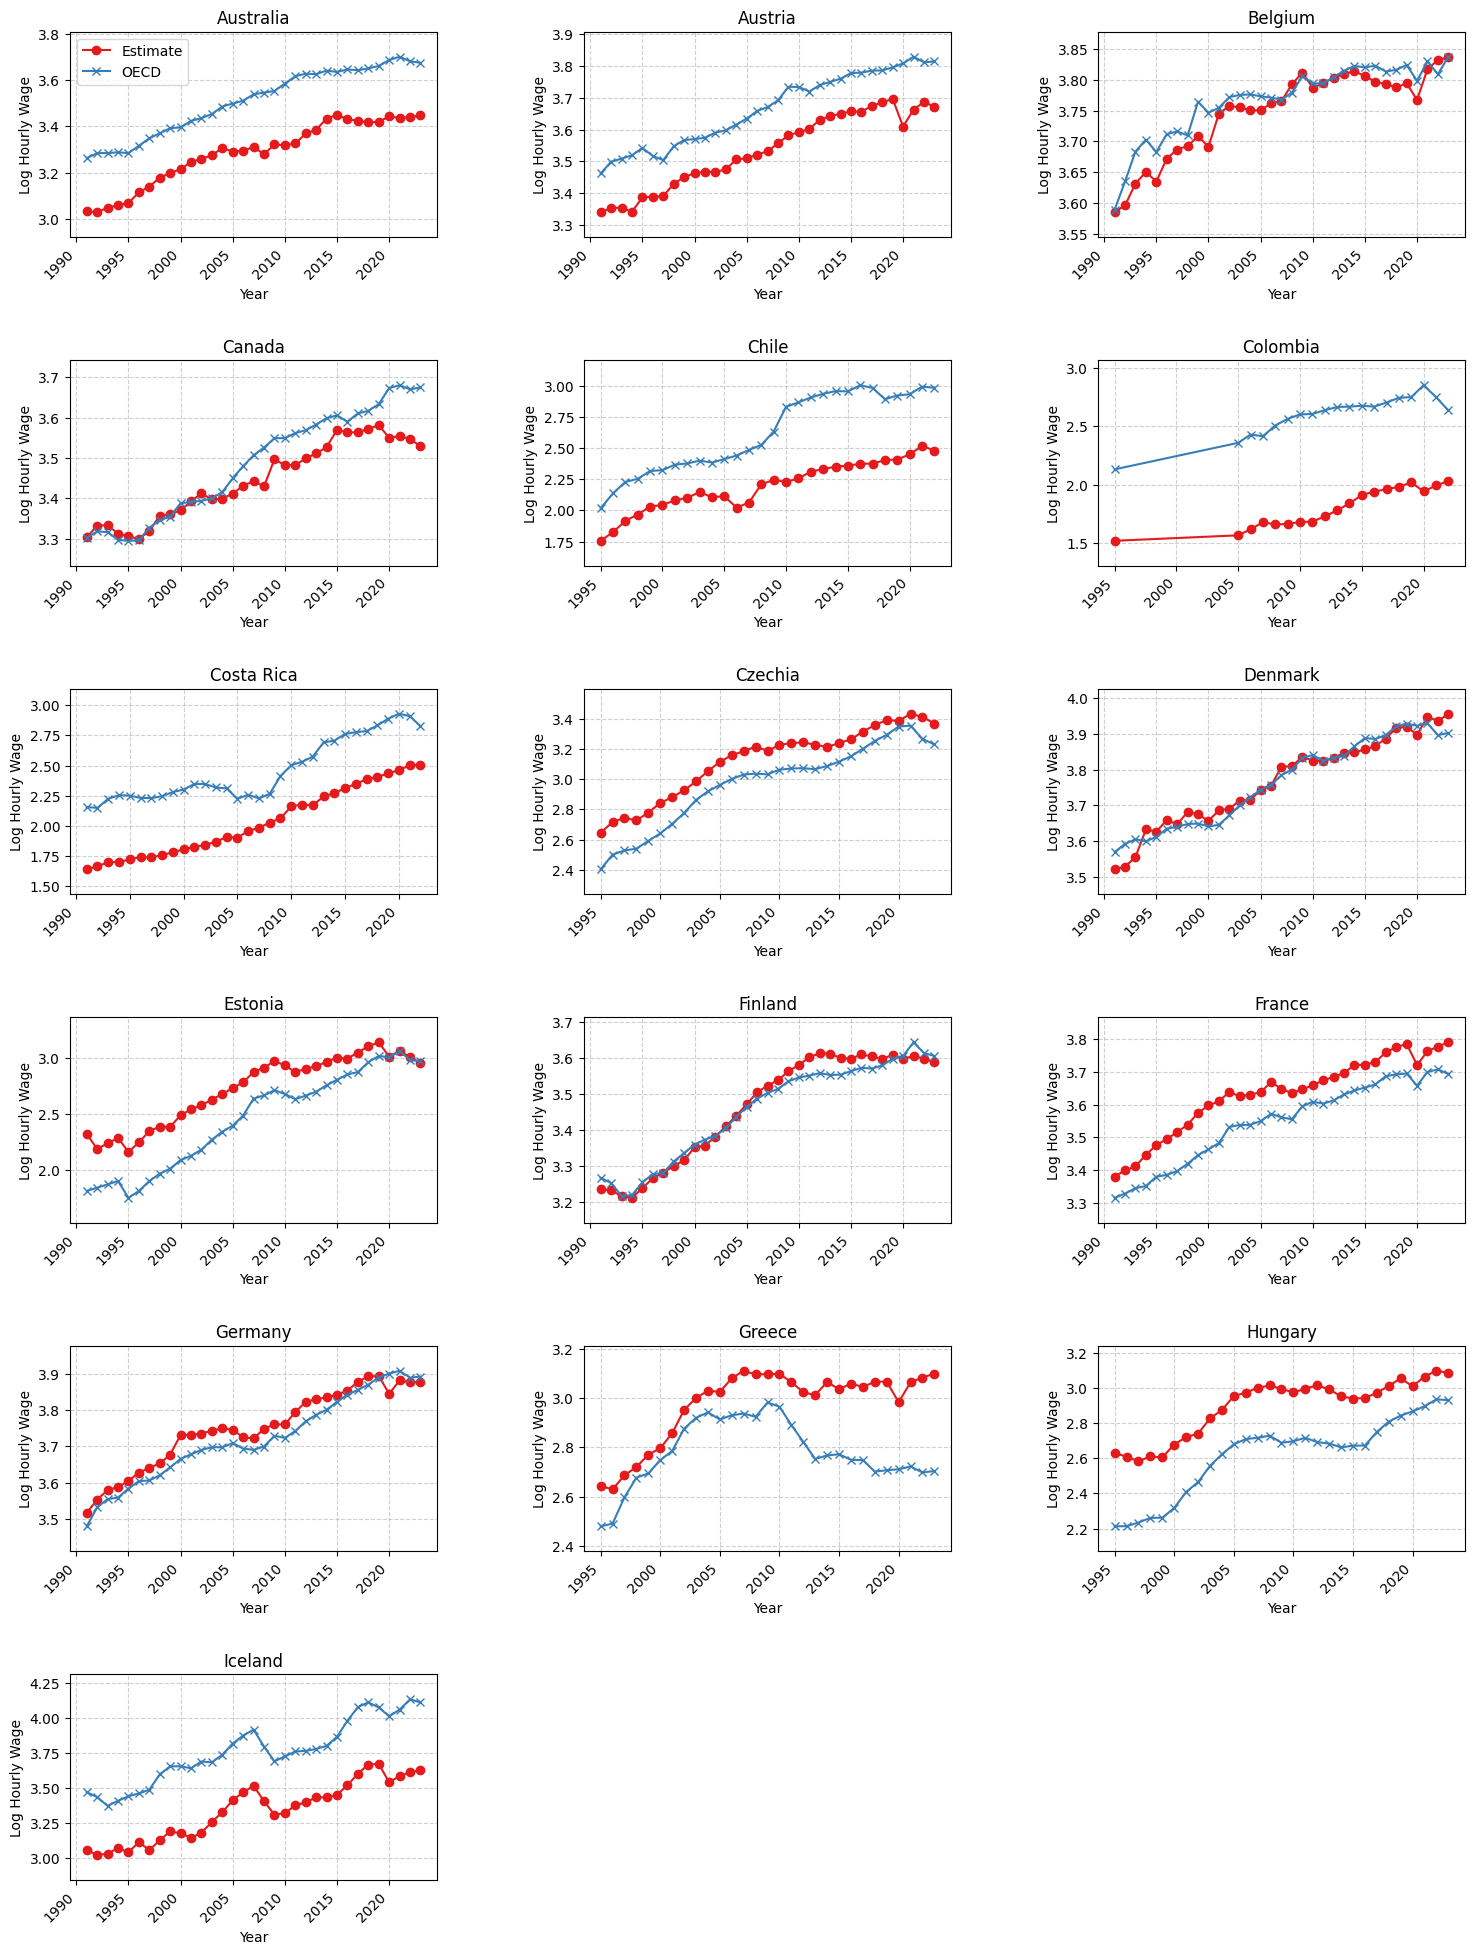

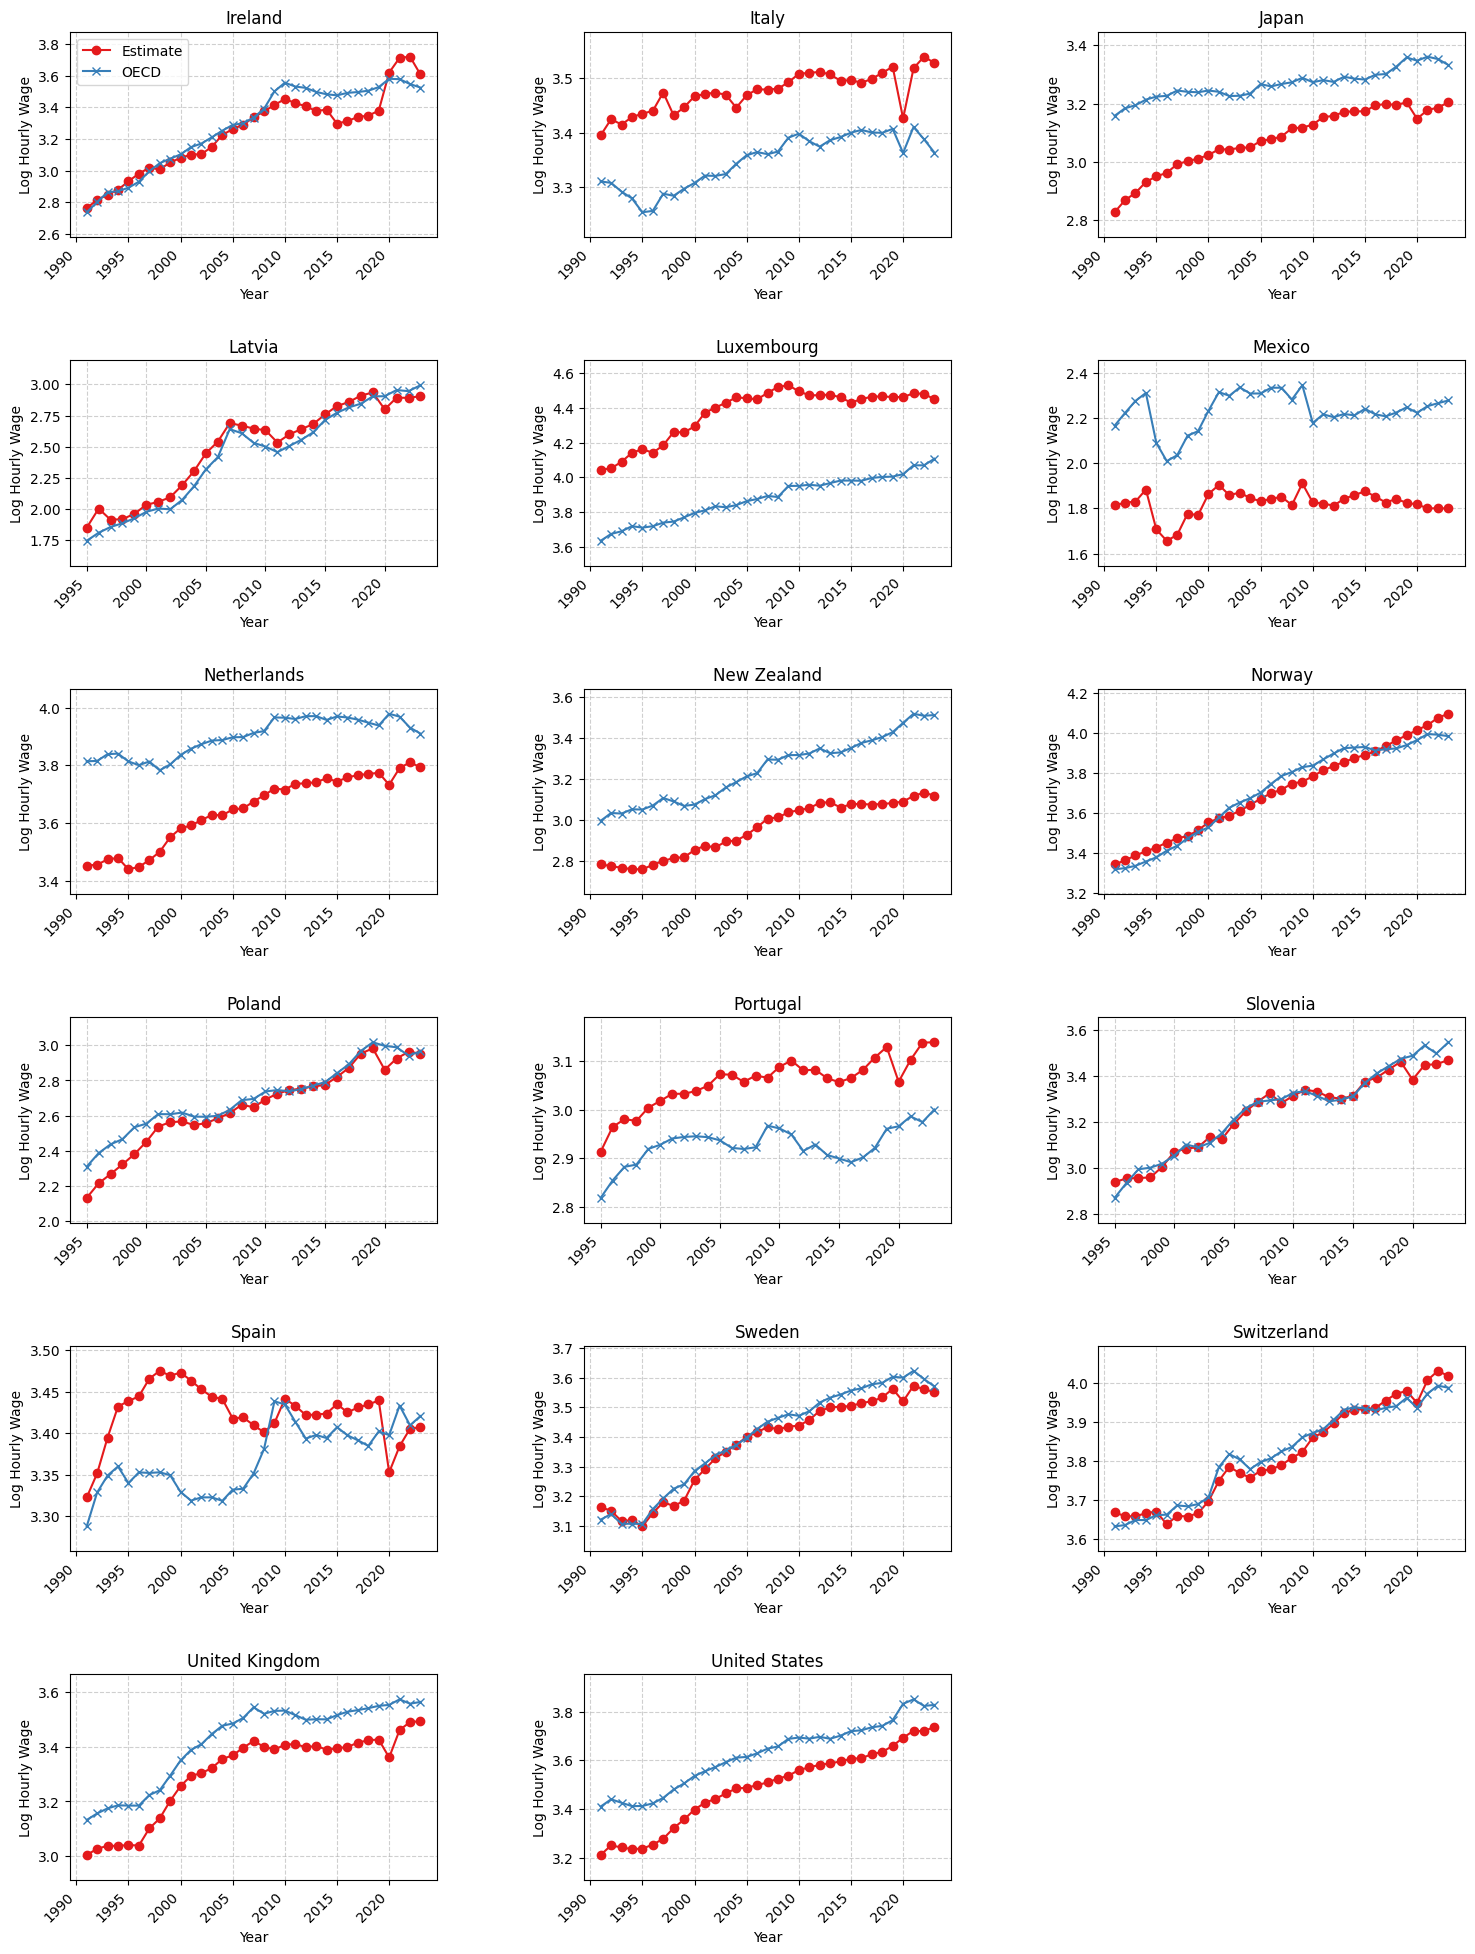

In [17]:
# — CONFIGURE THESE PATHS —
#EST_PATH  = os.path.expanduser('~/Documents/Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv')
#OECD_PATH = os.path.expanduser('~/Documents/Project_Wage_Convergence/OECD_wages_merged.csv')
#OUT_DIR   = os.path.expanduser('~/Documents/Project_Wage_Convergence/Plots')
#os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load and prepare
df_est = df.copy()
df_oecd = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/OECD_wages_merged.csv')
df_oecd.rename(columns={"Country":"country","Wages":"oecd_annual_wage","Year":"year"}, inplace=True)
df_oecd["year"] = pd.to_numeric(df_oecd["year"], errors="coerce")

df = pd.merge(df_est, df_oecd[["country","year","oecd_annual_wage"]],
              on=["country","year"], how="inner")
df["oecd_hourly_wage"] = df["oecd_annual_wage"] / df["whours"]
df["log_est"] = np.log(df["estimated_hourly_wage"])
df["log_oecd"] = np.log(df["oecd_hourly_wage"])

# 2) Split countries in two halves
countries = sorted(df["country"].dropna().unique())
half = len(countries)//2
batches = [countries[:half], countries[half:]]

from matplotlib.ticker import MultipleLocator

# 3) For each half, make a PDF with independent axes and 5-year ticks
for part, subset in enumerate(batches, start=1):
    n = len(subset)
    cols, rows = 3, math.ceil(n/3)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows),
                             sharex=False, sharey=False)
    axes = axes.flatten()

    for i, country in enumerate(subset):
        ax = axes[i]
        d = df[df["country"] == country].sort_values("year")

        # plot estimate vs. OECD
        ax.plot(d["year"], d["log_est"], '-o', label="Estimate", color=plt.cm.Set1(0))
        ax.plot(d["year"], d["log_oecd"], '-x', label="OECD",    color=plt.cm.Set1(1))

        # set ticks every 5 years
        start, end = d["year"].min(), d["year"].max()
        ax.set_xticks(np.arange(start - (start % 5), end + 1, 5))
        ax.xaxis.set_major_locator(MultipleLocator(5))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        ax.set_title(country, fontsize=12)
        ax.set_xlabel("Year")
        ax.set_ylabel("Log Hourly Wage")
        ax.grid(True, ls='--', alpha=0.6)
        if i == 0:
            ax.legend()

        # add 10% vertical padding
        y0, y1 = ax.get_ylim()
        dy = (y1 - y0) * 0.1
        ax.set_ylim(y0 - dy, y1 + dy)

    # hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    # adjust spacing
    plt.subplots_adjust(wspace=0.4, hspace=0.6)


    # save the plots
    #out_pdf = os.path.join(OUT_DIR, f"wage_comparison_part{part}.pdf")
    #fig.savefig(out_pdf, dpi=300)
    #plt.close(fig)
    #print(f"Saved {out_pdf}")


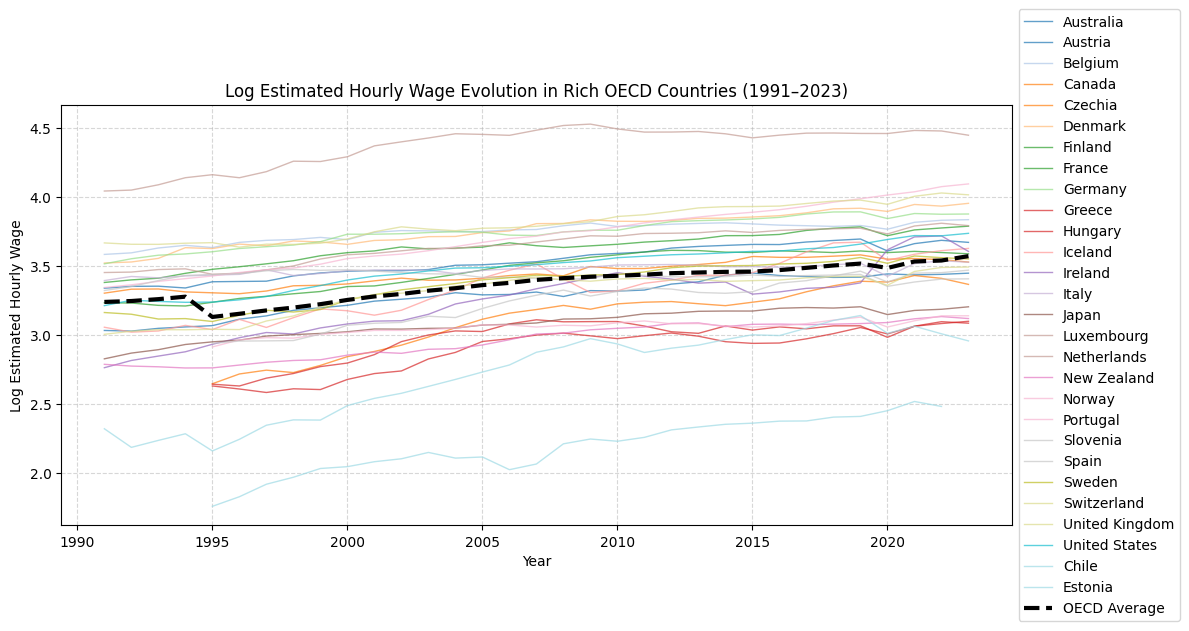

In [18]:

# 1) Load your estimated hourly‐wage data
df_est = df.copy()

# 2) Define the OECD benchmark group
oecd_countries = [
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Chile','Estonia'
]

# 3) Compute log of your estimated hourly wage
df_est['log_est'] = np.log(df_est['estimated_hourly_wage'])

# 4) Keep only OECD countries and pivot to wide form (years × countries)
df_oecd = df_est[df_est['country'].isin(oecd_countries)]
pivot = df_oecd.pivot(index='year', columns='country', values='log_est').sort_index()

# 5) Compute the OECD‐average log wage each year
pivot['OECD Average'] = pivot.mean(axis=1)

# 6) Plot all country lines plus the average
plt.figure(figsize=(12, 6))

# choose a qualitative colormap with enough distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, len(oecd_countries)))

for country, color in zip(oecd_countries, colors):
    if country in pivot:
        plt.plot(pivot.index, pivot[country],
                 label=country, color=color, linewidth=1, alpha=0.7)

# bold dashed line for the average
plt.plot(pivot.index, pivot['OECD Average'],
         label='OECD Average', color='k', linewidth=3, linestyle='--')

plt.xlabel('Year')
plt.ylabel('Log Estimated Hourly Wage')
plt.title('Log Estimated Hourly Wage Evolution in Rich OECD Countries (1991–2023)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 7) Save to PDF
#OUT_DIR = os.path.expanduser('~/Documents/Project_Wage_Convergence/Plots')
#os.makedirs(OUT_DIR, exist_ok=True)
#out_pdf = os.path.join(OUT_DIR, 'oecd_log_wage_evolution.pdf')
#plt.savefig(out_pdf, dpi=300)
plt.show()


In [19]:


# Identify the two countries with lowest log-wage in the final year
last = pivot.loc[pivot.index.max()]           # the 2023 row
lowest2 = last.drop('OECD Average').nsmallest(2)
print("Two countries with lowest log estimated wage in", pivot.index.max())
print(lowest2)

# --- after computing pivot and pivot['OECD Average'] ---
last_year = pivot.index.max()
last = pivot.loc[last_year]

# find the two lowest countries (excluding the average)
lowest2 = last.drop('OECD Average').nsmallest(2)

# build a small summary table
summary = pd.DataFrame({
    'log_wage':     lowest2,
    'level_wage':   np.exp(lowest2),
    'avg_level':    np.exp(last['OECD Average'])
})

# compute gap vs average in percent
summary['gap_vs_avg_%'] = (summary['avg_level'] - summary['level_wage']) / summary['avg_level'] * 100

print(f"Comparison for {last_year}:")
print(summary)


Two countries with lowest log estimated wage in 2023
country
Estonia    2.956992
Hungary    3.085540
Name: 2023, dtype: float64
Comparison for 2023:
         log_wage  level_wage  avg_level  gap_vs_avg_%
country                                               
Estonia  2.956992   19.240016  35.593653     45.945373
Hungary  3.085540   21.879280  35.593653     38.530389


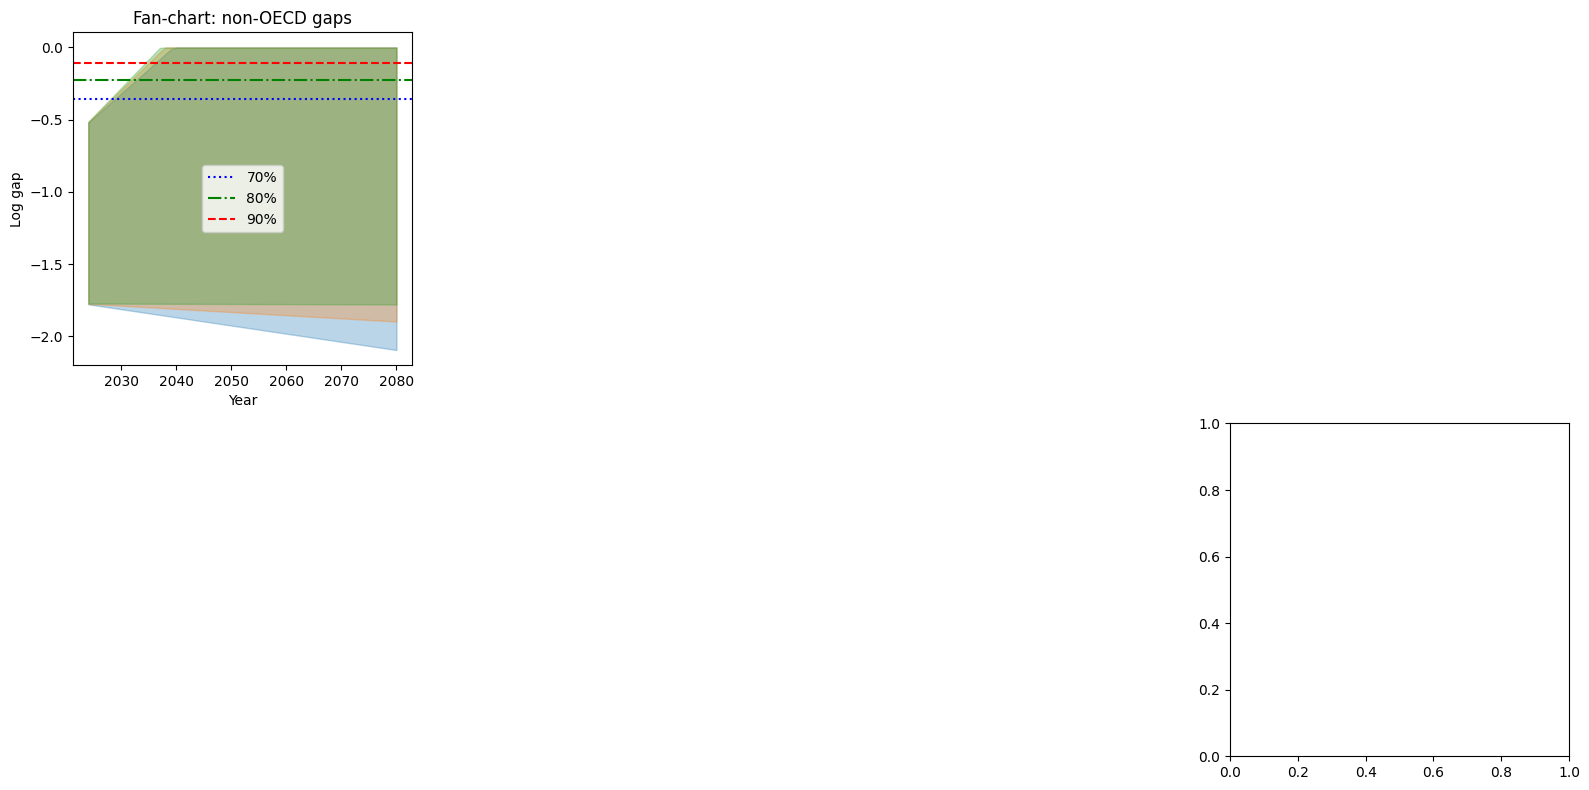

Written combined panels to /root/Downloads/combined_6countries_plus_fanchart.pdf


In [20]:
# ── INPUTS ─────────────────────────────────────────────────────────────────────
#EST_CSV     = os.path.expanduser('~/Documents/Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv')
#BENCH_CSV   = os.path.expanduser('~/Downloads/OECD_benchmark_scenarios.csv')
SUMMARY_CSV = os.path.expanduser('~/Downloads/V30_convergence_three_scenarios_nonOECD_plateau_summary.csv')
OUT_PDF     = os.path.expanduser('~/Downloads/combined_6countries_plus_fanchart.pdf')

# ── LOAD DATA ───────────────────────────────────────────────────────────────────
df = df.copy()
df['log_wage'] = np.log(df['estimated_hourly_wage'])
df['country'] = df['country'].str.replace('\u00A0',' ').str.strip()
bench = bench_df.copy()
res   = pd.read_csv(SUMMARY_CSV)

# build non-OECD sample
# Using the same set as before from the previous cell
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Chile','Estonia' # Added Chile and Estonia as per previous cell
}
df2 = (df.merge(bench, on='year', how='left')
         .query("country not in @oecd")
         .dropna(subset=['benchmark_high']))

# common histogram end and forecast horizon
H_END = df2['year'].max()                  # e.g. 2023
F_YEARS = np.arange(H_END+1, bench['year'].max()+1)

# pick six examples
res['L-70_num'] = pd.to_numeric(res['L-70'], errors='coerce')
fast  = res.dropna(subset=['L-70_num']).nsmallest(2,'L-70_num')['country'].tolist()
mids  = res.dropna(subset=['L-70_num']).sort_values('L-70_num')
midx  = len(mids)//2
mid   = mids.iloc[midx-1:midx+1]['country'].tolist()
never = res[res['L-70_num'].isna()].nlargest(2,'gap_low_2080')['country'].tolist()
potential_selected = fast + mid + never # Use a temporary list for potential candidates

# ── REFIT & COLLECT GAPS ────────────────────────────────────────────────────────
def get_gaps(sub):
    # fit linear trend on (year-H_END) even if shorter history
    tc = (sub['year'] - sub['year'].min()).values.reshape(-1,1)
    y  = sub['log_wage'].values
    # Check if there's enough data to fit the model
    if len(y) < 2: # LinearRegression needs at least 2 data points
        return None # Indicate that gaps cannot be calculated
    m  = LinearRegression().fit(tc, y)
    # hist gaps
    # Ensure the sub DataFrame contains 'benchmark_high' column
    if 'benchmark_high' not in sub.columns:
         return None # Indicate that gaps cannot be calculated
    gh = y - np.log(sub['benchmark_high'].values)
    # forecast on common horizon
    tc_f = (F_YEARS - sub['year'].min()).reshape(-1,1)
    yf   = m.predict(tc_f)
    gaps = {}
    for s in ['high','medium','low']:
        bench_vals = bench.set_index('year')[f'benchmark_{s}'].reindex(F_YEARS).values
        # Ensure bench_vals are not NaN or empty
        if np.isnan(bench_vals).any() or bench_vals.size == 0:
             return None # Indicate that gaps cannot be calculated
        raw = yf - np.log(bench_vals)
        gaps[s] = np.minimum(raw, 0.0)
    return sub['year'].values, gh, F_YEARS, gaps

# all non-OECD for fan
gaps_all = {}
for country in df2['country'].unique():
    country_data = df2[df2['country']==country].sort_values('year')
    if not country_data.empty:
        # Also ensure sufficient data length for the model
        if len(country_data) >= 2:
            gap_data = get_gaps(country_data)
            if gap_data is not None: # Check if get_gaps was successful
                gaps_all[country] = gap_data
            else:
                 print(f"Skipping country {country} due to insufficient data for gap calculation.")
        else:
             print(f"Skipping country {country} as it has less than 2 data points.")
    else:
        print(f"Skipping country {country} as it has no data in df2.") # This print is now redundant due to the loop structure

# Filter the selected countries to only include those present in gaps_all
selected = [c for c in potential_selected if c in gaps_all]

# Check if we still have enough countries to fill the plots
if len(selected) < 6:
    print(f"Warning: Only {len(selected)} countries available for plotting after filtering.")
    # You might want to adjust the plotting loop or figure size if less than 6 are available
    # For now, the code will proceed with fewer plots, which might leave empty axes

# ── PLOT 2×4 ────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2,4, figsize=(16,8))
ax_fan = axes[0,0]
others = axes.flatten()[1:7]

# fan‐chart
# Check if gaps_all is not empty before attempting to plot the fan chart
if gaps_all:
    # Use the data from the first country in gaps_all for years_hist etc.
    first_country_data = next(iter(gaps_all.values()))
    years_hist, _, years_fut, _ = first_country_data

    for scen,col in zip(['high','medium','low'],['C0','C1','C2']):
        # Ensure there is data for the scenario before plotting
        M = np.vstack([g[3][scen] for g in gaps_all.values()])
        ax_fan.fill_between(years_fut, M.min(0), M.max(0), color=col, alpha=0.3)

    for lvl,ls,col in [(0.7,':','blue'),(0.8,'-.','green'),(0.9,'--','red')]:
        ax_fan.axhline(np.log(lvl), ls=ls, color=col, label=f"{int(lvl*100)}%")
    ax_fan.set_title("Fan‐chart: non‐OECD gaps"); ax_fan.set_xlabel("Year"); ax_fan.set_ylabel("Log gap")
    ax_fan.legend()
else:
    # Hide the fan chart axis if no data is available
    ax_fan.set_visible(False)
    print("No data available to plot the fan chart.")


# country panels
# Iterate only up to the number of selected countries
for i, c in enumerate(selected):
    if i < len(others): # Ensure we don't go out of bounds for 'others' axes
        ax = others[i]
        yh, gh, yf, gf = gaps_all[c]
        ax.plot(yh, gh, 'k-o')
        for scen,col in zip(['high','medium','low'],['C0','C1','C2']):
            ax.plot(yf, gf[scen], '--', color=col)
        for lvl,ls,col in [(0.7,':','blue'),(0.8,'-.','green'),(0.9,'--','red')]:
            ax.axhline(np.log(lvl), ls=ls, color=col)
        ax.set_title(c); ax.set_xlabel("Year"); ax.set_ylabel("Log gap")
    else:
        # If selected list is longer than the available axes (shouldn't happen with 6 vs 6)
        # this would handle it, but len(others) is 6, and selected will be at most 6.
        pass


# hide any unused subplots if selected has fewer than 6 countries
for j in range(len(selected), len(others)):
     if j < len(axes.flatten()): # Ensure index is within flattened axes
        axes.flatten()[j+1].set_visible(False) # +1 because the first axis is the fan chart


plt.tight_layout()
plt.savefig(OUT_PDF, dpi=300)
plt.show()

print("Written combined panels to", OUT_PDF)